In [18]:
from __future__ import division
import os
import sys

from glob import glob

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [19]:
np.set_printoptions(threshold=np.nan)

In [20]:
def read_ms_file(fp):
    with open(fp) as fh:
        ## Skip first two lines
        fh.readline()
        fh.readline()

        ## Parse positions
        positions = map(float, fh.readline().replace('positions: ','').split())

        ## Make genotype array
        seqs = [map(int, j) for j in map(list, [x.strip() for x in fh])]
        gt = np.array(seqs)
        
        return positions,gt

In [22]:
def get_trajectories(baseDir):
    posANC,gtANC = read_ms_file(os.path.join(baseDir,'ms_ANC.txt'))
    posOOA,gtOOA = read_ms_file(os.path.join(baseDir,'ms_OOA.txt'))
    posAFR,gtAFR = read_ms_file(os.path.join(baseDir,'ms_AFR.txt'))
    posEUR,gtEUR = read_ms_file(os.path.join(baseDir,'ms_EUR.txt'))
    posEAS,gtEAS = read_ms_file(os.path.join(baseDir,'ms_EAS.txt'))
    
    ## Determine which positions are shared from beginning
#     shared = set.intersection(set(posANC),set(posOOA),set(posAFR),set(posEUR),set(posEAS))
    
    ## Get list of unique SNPs
    unique = set(posANC+posOOA+posAFR+posEUR+posEAS)
    
    ## Get AF trajectory for each SNP
    trajectories = []
#     for pos in sorted(list(shared)):
    for pos in sorted(list(unique)):
        afANC = gtANC[:,posANC.index(pos)].mean() if pos in posANC else 0
        afOOA = gtOOA[:,posOOA.index(pos)].mean() if pos in posOOA else 0
        afAFR = gtAFR[:,posAFR.index(pos)].mean() if pos in posAFR else 0
        afEUR = gtEUR[:,posEUR.index(pos)].mean() if pos in posEUR else 0
        afEAS = gtEAS[:,posEAS.index(pos)].mean() if pos in posEAS else 0
        afGAF = (afEUR+afEAS+afAFR)*(1/3)

        trajectories.append((afANC,afOOA,afAFR,afEUR,afEAS,afGAF))
    
    return trajectories

In [26]:
%%time
trajectories = []
for replicate in glob('/DATA/raw/sims/results/*'):
    res = get_trajectories(replicate)
    trajectories.extend(res)

CPU times: user 5.71 s, sys: 48 ms, total: 5.76 s
Wall time: 5.77 s


In [33]:
traj = pd.DataFrame(trajectories, columns=['af_ANC','af_OOA','af_AFR','af_EUR','af_EAS', 'GAF'])

In [28]:
traj['anc_cap'] = traj.apply(lambda x:True if x['af_ANC']>=0.05 else False, axis=1)

In [29]:
traj['ooa_cap'] = traj.apply(lambda x:True if x['af_OOA']>=0.05 else False, axis=1)

In [30]:
traj['global_cap'] = traj.apply(lambda x:True if x['GAF']>=0.05 else False, axis=1)

In [34]:
traj.head()

,af_ANC,af_OOA,af_AFR,af_EUR,af_EAS,GAF
0,0.00,0.00,0.02,0.00,0.00,0.006667
1,0.00,0.00,0.03,0.00,0.00,0.010000
2,0.11,0.22,0.15,0.55,0.38,0.360000
3,0.18,0.22,0.21,0.55,0.38,0.380000
4,0.00,0.00,0.01,0.00,0.00,0.003333


In [12]:
traj['anc_cap'].sum()

13553

In [13]:
traj['global_cap'].sum()

14694

In [14]:
traj.shape

(14940, 9)

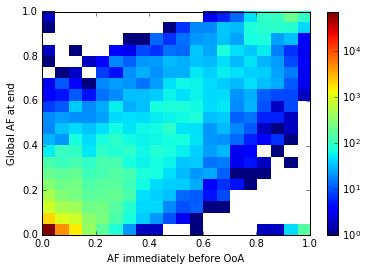

In [44]:
plt.hist2d(traj['af_ANC'],traj['GAF'], bins=np.linspace(0,1,21), norm=mpl.colors.LogNorm())
plt.colorbar()

ax = plt.gca()

ax.set_xlabel('AF immediately before OoA')
ax.set_ylabel('Global AF at end')

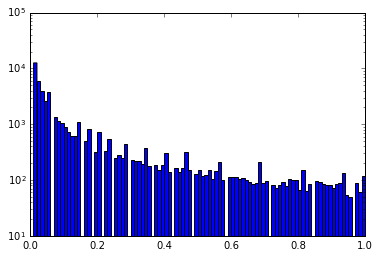

In [43]:
plt.hist(traj['af_ANC'], bins=np.linspace(0.01,1,100), log=True);

In [62]:
anc = traj[traj['af_ANC']>0]

In [63]:
anc.shape

(48876, 6)

(array([     0.,  12541.,   6005.,   3941.,   2619.,   1991.,   1725.,
          1341.,   1158.,   1049.,    888.,    730.,    625.,    615.,
           530.,    549.,    499.,    436.,    390.,    322.,    335.,
           387.,    330.,    293.,    257.,    245.,    285.,    245.,
           210.,    230.,    226.,    220.,    222.,    192.,    376.,
             0.,    175.,    188.,    154.,    186.,    303.,      0.,
           142.,    164.,    138.,    166.,    319.,      0.,    150.,
           128.,    148.,    118.,    125.,    150.,    105.,    143.,
           208.,      0.,    100.,    111.,    112.,    115.,    106.,
           110.,    102.,     91.,     84.,     87.,    210.,     90.,
             0.,     94.,     81.,     72.,     80.,     91.,     77.,
           103.,     98.,     98.,     66.,    150.,     64.,      0.,
            84.,     94.,     91.,     86.,     80.,     83.,     73.,
            84.,     90.,    132.,     54.,      0.,     49.,     88.,
      

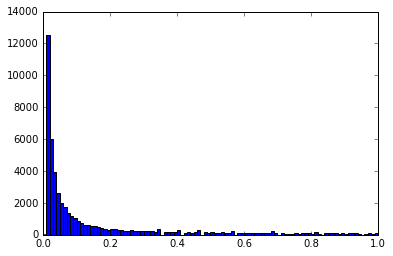

In [64]:
plt.hist(anc['af_ANC'], bins=np.linspace(0,1,101),)

In [65]:
anc['in_AFR'] = rare.apply(lambda x:True if x['af_AFR']>0 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [66]:
anc['in_EUR'] = rare.apply(lambda x:True if x['af_EUR']>0 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [67]:
anc['in_EAS'] = rare.apply(lambda x:True if x['af_EAS']>0 else False, axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [73]:
anc.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   False     18699.0
                True        216.0
        True    False       355.0
                True        628.0
True    False   False     10207.0
                True       1029.0
        True    False      2689.0
                True      15053.0
All                       48876.0
Name: af_ANC, dtype: float64

In [69]:
rare = anc[anc['af_ANC']<=0.01]

In [70]:
rare.shape

(12541, 9)

In [77]:
rare.pivot_table(values='af_ANC', index=['in_AFR','in_EUR','in_EAS'], aggfunc=np.count_nonzero, margins=True)

in_AFR  in_EUR  in_EAS
False   False   False      9894.0
                True         69.0
        True    False        90.0
                True        126.0
True    False   False      1733.0
                True         95.0
        True    False       188.0
                True        346.0
All                       12541.0
Name: af_ANC, dtype: float64